/root/miniconda3/envs/idemia_project/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch [1/3], Step [0/938], Loss: 1.3246
Epoch [1/3], Step [500/938], Loss: 0.0390
Epoch [2/3], Step [0/938], Loss: 0.0304
Epoch [2/3], Step [500/938], Loss: 0.0190
Epoch [3/3], Step [0/938], Loss: 0.0271
Epoch [3/3], Step [500/938], Loss: 0.0239


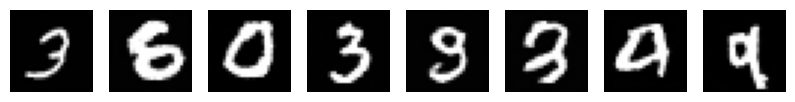

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the diffusion model
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=3,
    block_out_channels=(128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Define scheduler (timesteps and noise schedule)
scheduler = DDPMScheduler(num_train_timesteps=1000)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
epochs = 3
for epoch in range(epochs):
    for step, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Sample noise
        noise = torch.randn_like(images).to(device)
        timesteps = torch.randint(0, scheduler.num_train_timesteps, (images.shape[0],), device=device).long()

        # Add noise to images
        noisy_images = scheduler.add_noise(images, noise, timesteps)

        # Predict noise
        noise_pred = model(noisy_images, timesteps).sample

        # Compute loss (MSE between predicted and true noise)
        loss = nn.functional.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}/{len(dataloader)}], Loss: {loss.item():.4f}")

# Save trained model
torch.save(model.state_dict(), "ddpm_mnist.pth")

# Sampling from the trained model
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)

# Generate new images
num_samples = 8
model.eval()

generated_images = []

image = torch.randn((8, 1, 28, 28), device=device)
scheduler.set_timesteps(1000)
with torch.no_grad():
    for t in reversed(range(1000)):
        model_output = model(image, t).sample

        alpha_prod_t = scheduler.alphas_cumprod[t]

        z_zero = (image - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5

        image = scheduler.step(model_output, t, image).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()

generated_images.append(image)

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[0][i], cmap="gray")
    ax.axis("off")
plt.show()

In [2]:
# Define a simple CNN classifier
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

combined_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

# Train the classifier
num_epochs = 5
for epoch in range(num_epochs):
    for step, (images, labels) in enumerate(combined_dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = classifier(images)
        loss = criterion(outputs, labels)

        classifier_optimizer.zero_grad()
        loss.backward()
        classifier_optimizer.step()

        if step % 500 == 0:
            print(f"Classifier Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(combined_dataloader)}], Loss: {loss.item():.4f}")

# Save classifier model
torch.save(classifier.state_dict(), "mnist_classifier.pth")

# =====================================
# STEP 4: Evaluate Classifier
# =====================================
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

correct, total = 0, 0
classifier.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Classifier Accuracy: {100 * correct / total:.2f}%")

Classifier Epoch [1/5], Step [0/938], Loss: 2.3007
Classifier Epoch [1/5], Step [500/938], Loss: 0.1909
Classifier Epoch [2/5], Step [0/938], Loss: 0.0952
Classifier Epoch [2/5], Step [500/938], Loss: 0.0171
Classifier Epoch [3/5], Step [0/938], Loss: 0.0435
Classifier Epoch [3/5], Step [500/938], Loss: 0.0083
Classifier Epoch [4/5], Step [0/938], Loss: 0.0397
Classifier Epoch [4/5], Step [500/938], Loss: 0.0245
Classifier Epoch [5/5], Step [0/938], Loss: 0.0068
Classifier Epoch [5/5], Step [500/938], Loss: 0.0003
Classifier Accuracy: 98.89%


In [ ]:
<>

tensor([4, 8, 8, 8, 4, 7, 8, 8], device='cuda:0')


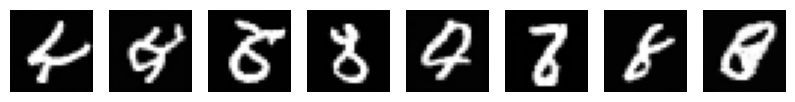

In [ ]:
num_samples = 8
model.eval()

generated_images = []

image = torch.randn((8, 1, 28, 28), device=device)
labels = torch.randint(low=1, high=9, size=(8,), device=device)
print(labels)
scheduler.set_timesteps(1000)

m = 10

for t in reversed(range(1000)):
    with torch.no_grad():
        model_output = model(image, t).sample

    alpha_prod_t = scheduler.alphas_cumprod[t]

    z_t = image.detach().clone()
    z_t.requires_grad_(True)
    z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5

    # z_zero = (image - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5
    # z_zero = z_zero.detach().clone()
    # z_zero.requires_grad_(True)
    loss = criterion(classifier(z_zero), labels)
    loss.backward()
    model_output += t**0.5 * z_t.grad

    # z_zero.requires_grad_(False)

    # backward pass
    # delta_z = torch.zeros(model_output.shape, device=device, requires_grad=True)
    # optim = torch.optim.SGD([delta_z])

    # for i in range(m):
    #     loss = criterion(classifier(z_zero), labels)
    #     optim.zero_grad()
    #     loss.backward()
    #     optim.step()

    # model_output -= (alpha_prod_t / (1 - alpha_prod_t)) ** 0.5 * delta_z.detach()


    image = scheduler.step(model_output, t, image).prev_sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

generated_images.append(image)

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[0][i], cmap="gray")
    ax.axis("off")
plt.show()

tensor([2, 1, 4, 4, 7, 4, 3, 6], device='cuda:0')


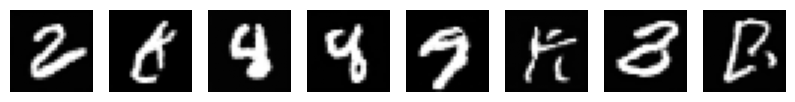

In [20]:
num_samples = 8
model.eval()

generated_images = []

image = torch.randn((8, 1, 28, 28), device=device)
labels = torch.randint(low=1, high=9, size=(8,), device=device)
print(labels)
scheduler.set_timesteps(1000)

m = 10

for t in reversed(range(1000)):
    with torch.no_grad():
        model_output = model(image, t).sample

    alpha_prod_t = scheduler.alphas_cumprod[t]

    z_t = image.detach().clone()
    z_t.requires_grad_(True)
    z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5
    # z_zero = z_zero.detach().clone()
    # z_zero.requires_grad_(True)
    loss = criterion(classifier(z_zero), labels)
    loss.backward()

    model_output += t**0.5 * z_t.grad

    # z_zero.requires_grad_(False)

    # backward pass
    # delta_z = torch.zeros(model_output.shape, device=device, requires_grad=True)
    # optim = torch.optim.SGD([delta_z])

    # for i in range(m):
    #     loss = criterion(classifier(z_zero), labels)
    #     optim.zero_grad()
    #     loss.backward()
    #     optim.step()

    # model_output -= (alpha_prod_t / (1 - alpha_prod_t)) ** 0.5 * delta_z.detach()


    image = scheduler.step(model_output, t, image).prev_sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

generated_images.append(image)

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[0][i], cmap="gray")
    ax.axis("off")
plt.show()

In [28]:
from tqdm import tqdm 

num_samples = 8
model.eval()

generated_images = []

image = torch.randn((8, 1, 28, 28), device=device, requires_grad=False)
labels = torch.randint(low=1, high=9, size=(8,), device=device)
print(labels)
scheduler.set_timesteps(1000)

m = 0
k = 10

grad_norm = []

for t in tqdm(reversed(range(1000))):
    image_prev = image
    for _ in range(k):
        image = image_prev
        z_t = image.detach().clone()
        z_t.requires_grad_(True)
        # with torch.no_grad():
        model_output = model(z_t, t).sample

        alpha_prod_t = scheduler.alphas_cumprod[t]
        alpha_prod_t_prev = scheduler.alphas_cumprod[t - 1] if (t - 1) >= 0 else torch.tensor(1.0)

        classifier.zero_grad()
        z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5
        # z_zero = z_zero.detach().clone()


        # z_zero = (image - (1 - alpha_prod_t) ** 0.5 * model_output) / alpha_prod_t ** 0.5
        # z_zero = z_zero.detach().clone()
        # z_zero.requires_grad_(True)
        loss = criterion(classifier(z_zero), labels)
        loss.backward()
        model_output += t**0.5 * z_t.grad # TODO change params 

        z_t.requires_grad_(False)
        z_zero = z_zero.detach().clone()
        z_zero.requires_grad_(False)

        # backward pass
        delta_z = torch.zeros(model_output.shape, device=device, requires_grad=True)
        optim = torch.optim.Adam([delta_z], lr=1e-2)

        for i in range(m):
            classifier.zero_grad()
            loss = criterion(classifier(z_zero + delta_z), labels)
            optim.zero_grad()
            loss.backward()
            optim.step()

        model_output -= (alpha_prod_t / (1 - alpha_prod_t)) ** 0.5 * delta_z.detach()

        image = scheduler.step(model_output, t, image).prev_sample
        image_prev = (alpha_prod_t/alpha_prod_t_prev)**0.5 * image \
            + (1 - alpha_prod_t/alpha_prod_t_prev)**0.5 * torch.randn_like(image)

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

generated_images.append(image)

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[0][i], cmap="gray")
    ax.axis("off")
plt.show()

tensor([8, 8, 4, 7, 1, 1, 7, 2], device='cuda:0')


1000it [09:13,  1.81it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

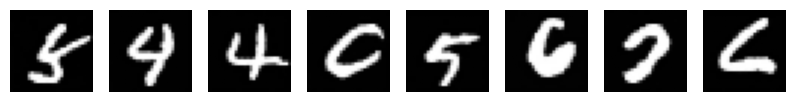

In [27]:
image = image.cpu().permute(0, 2, 3, 1).detach().numpy()

generated_images.append(image)

# Plot generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[0][i], cmap="gray")
    ax.axis("off")
plt.show()

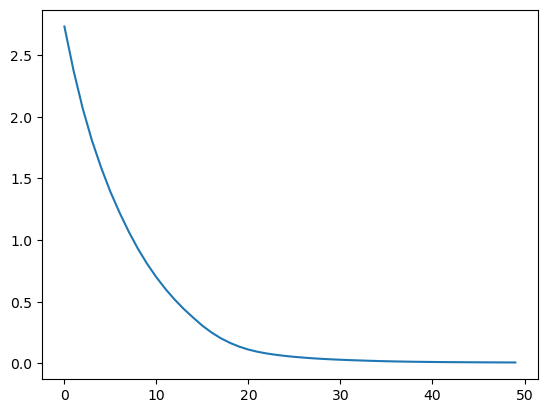

In [12]:
import matplotlib.pyplot as plt

plt.plot(grad_norm)